# Projeto 2 - Ciência dos Dados
## 2020.2 ~ 2C ~ Estudo do stat "Velocidade" dos Pokémons
### Grupo:
    -Guilherme Rameh
    -Tales Oliveira
    -Gabriella Zullo
    -João Magalhães

In [1]:
import scipy.stats as stats
from scipy.stats import t, norm, probplot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt, ceil
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

# Para ter melhor print
from IPython.display import display

In [2]:
# Leitura do banco de dados

dados = pd.read_csv('pokemon.csv')
dados

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,['Beast Boost'],0.25,1.0,0.5,2.0,0.5,1.0,2.0,0.5,1.0,...,NaN,797,107,101,61,steel,flying,999.9,7,1
797,['Beast Boost'],1.00,1.0,0.5,0.5,0.5,2.0,4.0,1.0,1.0,...,NaN,798,59,31,109,grass,steel,0.1,7,1
798,['Beast Boost'],2.00,0.5,2.0,0.5,4.0,2.0,0.5,1.0,0.5,...,NaN,799,97,53,43,dark,dragon,888.0,7,1
799,['Prism Armor'],2.00,2.0,1.0,1.0,1.0,0.5,1.0,1.0,2.0,...,NaN,800,127,89,79,psychic,NaN,230.0,7,1


# Primeira Análise Exploratória
A seguir, verificaremos quais variáveis achamos interessantes de se relacionar com a velocidade dos Pokémons, que é nossa variável *Target*. Começamos printando as colunas do dataframe, pois sabendo do que se trata, podemos descartar algumas colunas logo de cara (como por exemplo as colunas referentes a quanto de dano cada ataque dá em cada tipo de Pokémon).

In [3]:
print(dados.dtypes)

abilities             object
against_bug          float64
against_dark         float64
against_dragon       float64
against_electric     float64
against_fairy        float64
against_fight        float64
against_fire         float64
against_flying       float64
against_ghost        float64
against_grass        float64
against_ground       float64
against_ice          float64
against_normal       float64
against_poison       float64
against_psychic      float64
against_rock         float64
against_steel        float64
against_water        float64
attack                 int64
base_egg_steps         int64
base_happiness         int64
base_total             int64
capture_rate          object
classfication         object
defense                int64
experience_growth      int64
height_m             float64
hp                     int64
japanese_name         object
name                  object
percentage_male      float64
pokedex_number         int64
sp_attack              int64
sp_defense    

<b> Lembrete: Quando lidando com duas variáveis QUANTITATIVAS, usamos scatter plot, e para variáveis QUALITATÍVAS (como estamos lidando com "speed", que é quantitativo) podemos separar por index e fazer crosstab, ou usar o comando pivot table do pandas, que permite a análise de várias variáveis qualitativas em relação a quantitativas, permitindo até o uso de comandos como média, máx e mín.

### Primeiras modificações no Dataframe

A seguir, manipulamos o dataframe com o intuito de analisar a relação da velocidade com as principais variáveis quantitativas, como ataque, defesa, etc...; Para evitar confusões e dificuldade na leitura dos gráficos, primeiro separamos os tipos de pokémons nos mais frequentes, tanto para o *tipo 1* quanto para o *tipo 2*. Nessa etapa também separamos o dataframe em dois, um de treino e um para testarmos o quão fíel é o nosso modelo.

In [4]:
for i in dados.index:
    type1 = dados.type1[i]
    if type1 == 'water':
        dados.loc[dados.index==i, 'Type1Reorder'] = 'water'
    elif type1 == 'normal':
        dados.loc[dados.index==i, 'Type1Reorder'] = 'normal'
    else:
        dados.loc[dados.index==i, 'Type1Reorder'] = 'other'
        
    type2 = dados.type2[i]
    if type2 == 'flying':
        dados.loc[dados.index==i, 'Type2Reorder'] = 'flying'
    elif type2 == 'ground':
        dados.loc[dados.index==i, 'Type2Reorder'] = 'ground'
    else:
        dados.loc[dados.index==i, 'Type2Reorder'] = 'other'
        
dados.tail(20)

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary,Type1Reorder,Type2Reorder
781,"['Bulletproof', 'Soundproof', 'Overcoat']",1.00,1.0,2.0,0.5,2.0,1.00,0.5,1.0,1.0,...,45,45,45,dragon,NaN,29.7,7,0,other,other
782,"['Bulletproof', 'Soundproof', 'Overcoat']",0.50,0.5,2.0,0.5,4.0,1.00,0.5,2.0,1.0,...,65,70,65,dragon,fighting,47.0,7,0,other,other
783,"['Bulletproof', 'Soundproof', 'Overcoat']",0.50,0.5,2.0,0.5,4.0,1.00,0.5,2.0,1.0,...,100,105,85,dragon,fighting,78.2,7,0,other,other
784,"['Electric Surge', 'Telepathy']",0.50,0.5,0.0,0.5,1.0,0.50,1.0,0.5,1.0,...,95,75,130,electric,fairy,20.5,7,1,other,other
785,"['Psychic Surge', 'Telepathy']",1.00,1.0,0.0,1.0,1.0,0.25,1.0,1.0,2.0,...,130,115,95,psychic,fairy,18.6,7,1,other,other
786,"['Grassy Surge', 'Telepathy']",1.00,0.5,0.0,0.5,1.0,0.50,2.0,2.0,1.0,...,85,95,75,grass,fairy,45.5,7,1,other,other
787,"['Misty Surge', 'Telepathy']",0.50,0.5,0.0,2.0,1.0,0.50,0.5,1.0,1.0,...,95,130,85,water,fairy,21.2,7,1,water,other
788,['Unaware'],2.00,2.0,1.0,1.0,1.0,0.50,1.0,1.0,2.0,...,29,31,37,psychic,NaN,0.1,7,1,other,other
789,['Sturdy'],2.00,2.0,1.0,1.0,1.0,0.50,1.0,1.0,2.0,...,29,131,37,psychic,NaN,999.9,7,1,other,other
790,['Full Metal Body'],1.00,2.0,0.5,1.0,0.5,1.00,2.0,0.5,2.0,...,113,89,97,psychic,steel,230.0,7,1,other,other


In [5]:
lista_train_test = train_test_split(dados, shuffle=True)
train = lista_train_test[0]
test = lista_train_test[1]

# size = 600
# list_of_dfs = [shuffle.iloc[:600,:], shuffle.iloc[600:,:]]
# train = list_of_dfs[0]
# test = list_of_dfs[1]

In [6]:
# Aqui vemos a quantidade de cada tipo, 1 e 2, na base de treino

print(train['type1'].value_counts())
print('\n')
print(train['type2'].value_counts())

water       82
normal      81
bug         57
grass       53
fire        41
rock        37
psychic     36
electric    30
ground      25
ghost       23
poison      23
dark        20
steel       20
fighting    20
dragon      18
ice         18
fairy       14
flying       2
Name: type1, dtype: int64


flying      67
poison      27
psychic     23
fairy       22
fighting    21
ground      20
dark        18
steel       17
grass       16
dragon      14
water       14
rock        12
ice         11
ghost       10
fire         9
electric     8
bug          4
normal       3
Name: type2, dtype: int64


### Análise com o modelo de distribuição "Normal"

Na célula seguinte, usamos o *probplot* e um histograma para analisar a normalidade da variável 'velocidade'. Podemos ver que ela não se distancia tanto da normal, principalmente na cauda esquerda.

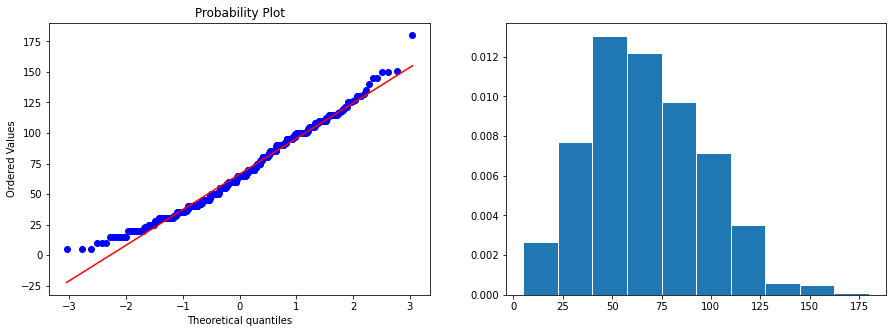

In [7]:
plt.figure(figsize=(15,5))

plt.subplot(121)
probplot(train['speed'], dist='norm', plot=plt)

plt.subplot(122)
plt.hist(train['speed'], density=True, edgecolor='w');

## Plot inicial
Como maneira de visualizar melhor se as variáveis tem relação ao *Target*, plotamos os gráficos *scatterplot* de relação entre as diversas variáveis quantitativas, além de separar por tipos de Pokémon, para ver se com isso conseguíamos visualizar alguma relação, que como se perceberá logo, é bem difícil.

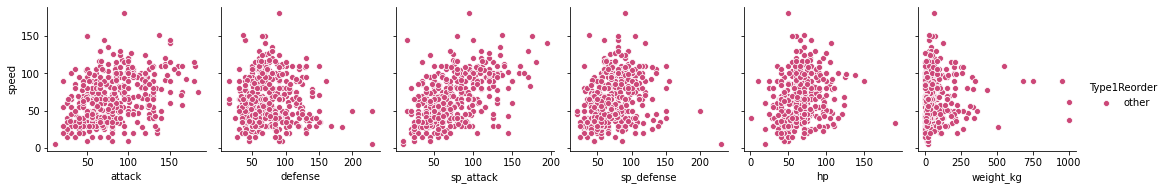

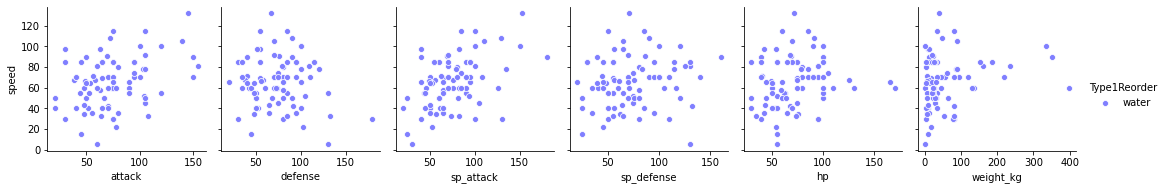

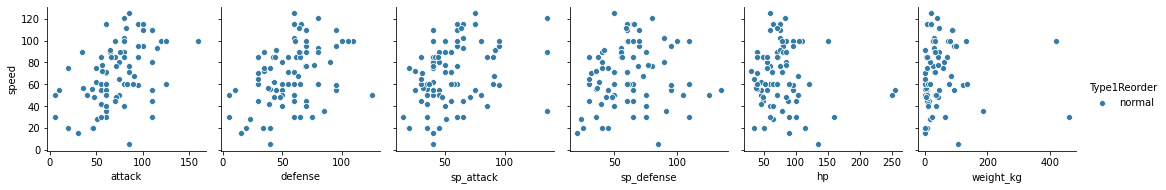

In [8]:
listType1 = train.Type1Reorder.unique()
listType2 = train.Type2Reorder.unique()
colorlist = ['plasma', 'cool', 'mako']

for i in range(3):
    e = listType1[i]
    df = train.loc[train.Type1Reorder==e, :]
    sns.pairplot(df, palette=colorlist[i],
        x_vars=["attack", 'defense', 'sp_attack', 'sp_defense', 'hp', 'weight_kg'],
        y_vars=['speed'],
        hue='Type1Reorder', height=2.5);

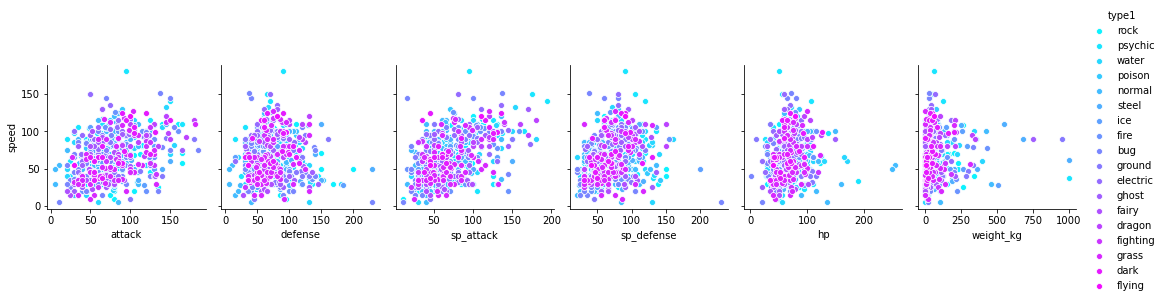

In [9]:
sns.pairplot(train,
        x_vars=["attack", 'defense', 'sp_attack', 'sp_defense', 'hp', 'weight_kg'],
        y_vars=['speed'], palette='cool',hue='type1', height=2.5);

## Regressão
Percebendo que assim não conseguiríamos identificar nenhuma relação, optamos por usar a biblioteca <b>statsmodel.api</b> para fazer a regressão pelo método dos Mínimos Quadrados. 

*Usamos apenas algumas variáveis, pois no contexto do dataframe e do jogo Pokémon sabemos que fazem referência a outros detalhes que não vão influenciar na velocidade do Pokémon, além de alguns conterem termos NaN, que atrapalham o uso deles como treino*

In [10]:
X = train[['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'is_legendary', 'generation', 'experience_growth']]

Y = train[['speed']]

In [11]:
def regress(Y,X):
    '''
    Y: coluna do DataFrame utilizada como variável resposta (TARGET)
    X: coluna(s) do DataFrame utilizadas como variável(is) explicativas (FEATURES)
    '''
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    
    return results

In [12]:
results = regress(Y,X)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     41.45
Date:                Thu, 19 Nov 2020   Prob (F-statistic):           1.45e-52
Time:                        15:17:52   Log-Likelihood:                -2743.3
No. Observations:                 600   AIC:                             5505.
Df Residuals:                     591   BIC:                             5544.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                43.1427      7.637      5.649      0.000      28.144      58.142
attack                0.3250      0.037      8.745      0.000       0.252       0.398
defense              -0.3085      0.042     -7.411      0.000      -0.390      -0.227
sp_attack             0.2884      0.037      7.778      0.000       0.216       0.361
sp_defense            0.1412      0.048      2.954      0.003       0.047       0.235
hp                   -0.1023      0.043     -2.391      0.017      -0.186      -0.018
is_legendary         15.5333      4.147      3.745      0.000       7.388      23.679
generation           -0.9940      0.515     -1.928      0.054      -2.006       0.018
experience_growth -6.592e-07   6.61e-06     -0.100      0.921   -1.36e-05    1.23e-05
==============================================================================
Omnibus:                       11.011   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.360
Skew:                           0.290   Prob(JB):                      0.00341
Kurtosis:                       3.343   Cond. No.                     8.72e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.72e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Analisando os resultados acima, percebemos que TODOS (com excessão de "experience_growth") são importantes para definir nossa variável *Target*, ou seja, a velocidade ("speed"). Apesar disso, nosso P é bem pequeno, o que não é um bom sinal, e portanto precisaremos de mais regressões se quisermos atingir a normalidade e poder prever fielmente nosso *Target*.

## Análise Rápida da previsão "como está"
Apenas para visualizarmos, abaixo segue o plot do predict (ou seja, a previsão que a biblioteca $sm$ faz) relacionado com os valores reais do nosso dataframe *teste*.

In [13]:
X_test = test[['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'is_legendary', 'generation', 'experience_growth']]

Y_test = test[['speed']]

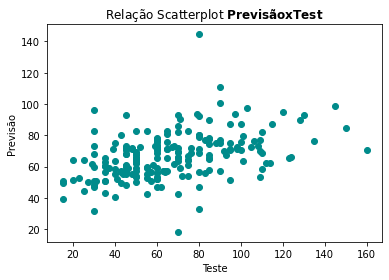

In [14]:
X_cp = sm.add_constant(X_test)
Y_predTest = results.predict(X_cp)

plt.title(r'Relação Scatterplot $\bf{Previsão x Test}$')
plt.xlabel('Teste')
plt.ylabel('Previsão')
plt.scatter(Y_test, Y_predTest, color='darkcyan');

## Aprofundamento na Análise Exploratória
Para aprimorarmos nossa previsão da velocidade dos Pokémons, precisamos também considerar variáveis <b>qualitativas</b>. Porém, a biblioteca $sm$ lida apenas com variáveis <b>quantitativas</b>. Como podemos então transformar essas variáveis para podermos analisar melhor nosso dataframe? A resposta é: com $Dummies$. Dummies é um comando da biblioteca $pandas$ que transforma as strings de uma classificação qualitativa em colunas de um dataframe assumindo valores de 0 ou 1, que equivalem a False e True, respectivamente. Assim, podemos usar essas novas colunas para uma análise exploratória mais aprofundada.

### Type 1

In [15]:
dummies_type1 = pd.get_dummies(train['type1'])
dummies_type2 = pd.get_dummies(train['type2'])

In [16]:
X_Type1 = dummies_type1 
X_Type2 = dummies_type2

In [17]:
results = regress(Y,X_Type1)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     3.657
Date:                Thu, 19 Nov 2020   Prob (F-statistic):           1.12e-06
Time:                        15:17:53   Log-Likelihood:                -2846.5
No. Observations:                 600   AIC:                             5729.
Df Residuals:                     582   BIC:                             5808.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.2182      1.582     40.605      0.000      61.112      67.324
bug           -5.0779      3.874     -1.311      0.191     -12.688       2.532
dark          15.0818      6.177      2.442      0.015       2.950      27.214
dragon        18.8373      6.490      2.903      0.004       6.091      31.584
electric      23.3151      5.126      4.549      0.000      13.248      33.382
fairy        -12.3611      7.310     -1.691      0.091     -26.718       1.996
fighting       4.8318      6.177      0.782      0.434      -7.300      16.964
fire          10.5135      4.460      2.357      0.019       1.753      19.274
flying        23.7818     18.948      1.255      0.210     -13.434      60.997
ghost         -3.3487      5.788     -0.579      0.563     -14.717       8.020
grass         -8.4824      3.994     -2.124      0.034     -16.328      -0.637
ground        -1.8982      5.570     -0.341      0.733     -12.838       9.041
ice           -5.4404      6.490     -0.838      0.402     -18.187       7.306
normal         5.0287      3.362      1.496      0.135      -1.575      11.632
poison         0.8687      5.788      0.150      0.881     -10.500      12.237
psychic       11.8929      4.723      2.518      0.012       2.616      21.170
rock          -8.6236      4.666     -1.848      0.065     -17.788       0.541
steel         -5.5682      6.177     -0.901      0.368     -17.700       6.564
water          0.8671      3.346      0.259      0.796      -5.705       7.439
==============================================================================
Omnibus:                       15.548   Durbin-Watson:                   2.148
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.355
Skew:                           0.404   Prob(JB):                     0.000281
Kurtosis:                       2.961   Cond. No.                     1.21e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.43e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Analisando a regressão da variável Tipo 1
Analisando essa primeira tabela da regressão, percebe-se uma forte relação dos tipos electric, fire e flying com a velocidade. Seguimos aprofundando na análise. 

In [18]:
X_Type1 = dummies_type1.loc[:, ['electric', 'fire', 'flying']]
results = regress(Y,X_Type1)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     7.748
Date:                Thu, 19 Nov 2020   Prob (F-statistic):           4.40e-05
Time:                        15:17:53   Log-Likelihood:                -2865.4
No. Observations:                 600   AIC:                             5739.
Df Residuals:                     596   BIC:                             5756.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.4061      1.254     51.350      0.000      61.943      66.869
electric      23.1273      5.404      4.279      0.000      12.513      33.741
fire          10.3256      4.668      2.212      0.027       1.157      19.494
flying        23.5939     20.399      1.157      0.248     -16.468      63.656
==============================================================================
Omnibus:                       16.259   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.182
Skew:                           0.409   Prob(JB):                     0.000186
Kurtosis:                       2.861   Cond. No.                         17.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Type 2

In [19]:
results = regress(Y,X_Type2)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     3.376
Date:                Thu, 19 Nov 2020   Prob (F-statistic):           3.47e-06
Time:                        15:17:53   Log-Likelihood:                -2847.1
No. Observations:                 600   AIC:                             5732.
Df Residuals:                     581   BIC:                             5816.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.6232      1.678     38.504      0.000      61.327      67.920
bug           -7.8732     14.241     -0.553      0.581     -35.844      20.097
dark          13.9323      6.875      2.027      0.043       0.430      27.434
dragon         3.0910      7.743      0.399      0.690     -12.117      18.299
electric      -0.8732     10.140     -0.086      0.931     -20.788      19.042
fairy         -0.8960      6.259     -0.143      0.886     -13.190      11.398
fighting      19.6149      6.396      3.067      0.002       7.052      32.177
fire           4.1545      9.576      0.434      0.665     -14.654      22.963
flying        17.4066      3.841      4.531      0.000       9.862      24.951
ghost        -11.0232      9.100     -1.211      0.226     -28.897       6.850
grass         -8.7482      7.267     -1.204      0.229     -23.022       5.525
ground        -4.6232      6.543     -0.707      0.480     -17.475       8.228
ice            3.7404      8.691      0.430      0.667     -13.330      20.811
normal        18.0434     16.416      1.099      0.272     -14.198      50.285
poison        -4.4751      5.696     -0.786      0.432     -15.663       6.712
psychic        6.4637      6.132      1.054      0.292      -5.579      18.507
rock         -29.2899      8.336     -3.514      0.000     -45.661     -12.918
steel         -5.6232      7.062     -0.796      0.426     -19.494       8.247
water        -10.7661      7.743     -1.390      0.165     -25.974       4.442
==============================================================================
Omnibus:                       20.581   Durbin-Watson:                   2.120
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.004
Skew:                           0.469   Prob(JB):                     1.67e-05
Kurtosis:                       3.044   Cond. No.                         14.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Analisando a regressão da variável Tipo 2
Analisando essa tabela da regressão, percebe-se uma forte relação dos tipos2 fighting, flying, e rock com a velocidade. Seguimos aprofundando na análise. 

In [20]:
X_Type2 = dummies_type2.loc[:, ['fighting', 'flying', 'rock']]
results = regress(Y,X_Type2)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     15.41
Date:                Thu, 19 Nov 2020   Prob (F-statistic):           1.14e-09
Time:                        15:17:53   Log-Likelihood:                -2854.5
No. Observations:                 600   AIC:                             5717.
Df Residuals:                     596   BIC:                             5735.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.2380      1.264     50.805      0.000      61.755      66.721
fighting      20.0001      6.298      3.176      0.002       7.631      32.369
flying        17.7919      3.678      4.837      0.000      10.568      25.016
rock         -28.9047      8.259     -3.500      0.001     -45.125     -12.684
==============================================================================
Omnibus:                       19.858   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.301
Skew:                           0.461   Prob(JB):                     2.37e-05
Kurtosis:                       2.959   Cond. No.                         7.22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regressão Aprofundada
Agora que temos alguma noção de quais variáveis importam para nós e quais não, podemos fazer uma regressão apenas com essas variáveis, e ver se conseguimos usar esse modelo para prever com mais precisão a base de *teste*.

In [21]:
# Type1 importantes: electric, fire, flying
# Type2 importantes: fighting, flying, rock

Type1Imp = ['electric', 'fire', 'flying']
Type2Imp = ['fighting', 'flying', 'rock']

# Usaremos essas listas para criar colunas personalizadas no dataframe Train para poder diferenciar type1 de type2
# Assim, já podemos aproveitar e usar os dataframse de Dummies para isso

for i in range(3):
    train.loc[:,'T1_'+Type1Imp[i]] = dummies_type1[Type1Imp[i]]
    train.loc[:,'T2_'+Type2Imp[i]] = dummies_type2[Type2Imp[i]]
    
train

E:\Arquivos de Programas\Anaconda\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
E:\Arquivos de Programas\Anaconda\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,generation,is_legendary,Type1Reorder,Type2Reorder,T1_electric,T2_fighting,T1_fire,T2_flying,T1_flying,T2_rock
524,"['Sturdy', 'Weak Armor', 'Sand Force']",1.0,1.0,1.0,1.0,1.0,2.00,0.5,0.5,1.0,...,5,0,other,other,0,0,0,0,0,0
578,"['Overcoat', 'Magic Guard', 'Regenerator']",2.0,2.0,1.0,1.0,1.0,0.50,1.0,1.0,2.0,...,5,0,other,other,0,0,0,0,0,0
381,['Drizzle'],1.0,1.0,1.0,2.0,1.0,1.00,0.5,1.0,1.0,...,3,1,water,other,0,0,0,0,0,0
338,"['Oblivious', 'Anticipation', 'Hydration']",1.0,1.0,1.0,0.0,1.0,1.00,0.5,1.0,1.0,...,3,0,water,ground,0,0,0,0,0,0
341,"['Hyper Cutter', 'Shell Armor', 'Adaptability']",2.0,0.5,1.0,2.0,2.0,2.00,0.5,1.0,0.5,...,3,0,water,other,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722,"['Overgrow', 'Long Reach']",1.0,1.0,1.0,1.0,1.0,0.50,2.0,2.0,1.0,...,7,0,other,flying,0,0,0,1,0,0
29,"['Poison Point', 'Rivalry', 'Hustle']",0.5,1.0,1.0,1.0,0.5,0.50,1.0,1.0,1.0,...,1,0,other,other,0,0,0,0,0,0
638,['Justified'],0.5,0.5,1.0,1.0,2.0,2.00,0.5,1.0,1.0,...,5,1,other,other,0,1,0,0,0,0
413,"['Swarm', 'Tinted Lens']",0.5,1.0,1.0,2.0,1.0,0.25,2.0,2.0,1.0,...,4,0,other,flying,0,0,0,1,0,0


In [22]:
X_comp = train[['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'is_legendary', 'generation',
                'T1_electric', 'T2_fighting', 'T1_fire', 'T2_flying', 'T1_flying', 'T2_rock']]

In [23]:
results = regress(Y,X_comp)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     30.18
Date:                Thu, 19 Nov 2020   Prob (F-statistic):           5.65e-57
Time:                        15:17:53   Log-Likelihood:                -2723.2
No. Observations:                 600   AIC:                             5474.
Df Residuals:                     586   BIC:                             5536.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           38.8342      4.039      9.614      0.000      30.901      46.767
attack           0.3134      0.036      8.606      0.000       0.242       0.385
defense         -0.2644      0.043     -6.090      0.000      -0.350      -0.179
sp_attack        0.2624      0.037      7.105      0.000       0.190       0.335
sp_defense       0.1382      0.047      2.970      0.003       0.047       0.230
hp              -0.0888      0.042     -2.125      0.034      -0.171      -0.007
is_legendary    13.2632      3.936      3.370      0.001       5.534      20.993
generation      -0.9923      0.505     -1.965      0.050      -1.984      -0.001
T1_electric     15.4874      4.408      3.513      0.000       6.829      24.145
T2_fighting      9.0983      5.336      1.705      0.089      -1.382      19.578
T1_fire          0.6421      3.854      0.167      0.868      -6.927       8.211
T2_flying       14.6611      2.993      4.899      0.000       8.783      20.539
T1_flying       18.7875     16.364      1.148      0.251     -13.352      50.927
T2_rock        -10.6372      7.206     -1.476      0.140     -24.789       3.515
==============================================================================
Omnibus:                       13.508   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.170
Skew:                           0.326   Prob(JB):                     0.000838
Kurtosis:                       3.377   Cond. No.                     2.95e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.95e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
# T1_fire, T1_flying e T2_rock não são importantes, e podemos descartá-los

X_comp = train[['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'is_legendary', 'generation',
                'T1_electric', 'T2_fighting', 'T2_flying']]

results = regress(Y,X_comp)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     38.85
Date:                Thu, 19 Nov 2020   Prob (F-statistic):           1.33e-58
Time:                        15:17:53   Log-Likelihood:                -2724.9
No. Observations:                 600   AIC:                             5472.
Df Residuals:                     589   BIC:                             5520.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           39.3361      4.024      9.776      0.000      31.433      47.239
attack           0.3166      0.036      8.719      0.000       0.245       0.388
defense         -0.2881      0.041     -7.102      0.000      -0.368      -0.208
sp_attack        0.2654      0.036      7.292      0.000       0.194       0.337
sp_defense       0.1466      0.046      3.176      0.002       0.056       0.237
hp              -0.0926      0.042     -2.222      0.027      -0.174      -0.011
is_legendary    14.0060      3.902      3.589      0.000       6.342      21.670
generation      -0.9199      0.503     -1.828      0.068      -1.909       0.069
T1_electric     15.2724      4.390      3.479      0.001       6.650      23.895
T2_fighting      9.3068      5.257      1.770      0.077      -1.018      19.631
T2_flying       14.7013      2.991      4.914      0.000       8.826      20.577
==============================================================================
Omnibus:                       13.304   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.812
Skew:                           0.329   Prob(JB):                      0.00100
Kurtosis:                       3.345   Cond. No.                         954.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
# Mais uma vez, mas agora vamos remover todos aqueles que não têm pelo menos 3 casas decimais de 0 (o valor deve ser 0.000)
# Esses valores são: sp_defense, generation, T2_fighting

X_comp = train[['attack', 'defense', 'sp_attack', 'sp_defense', 'is_legendary', 'T1_electric', 'T2_flying', 'generation']]

results = regress(Y,X_comp)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     47.09
Date:                Thu, 19 Nov 2020   Prob (F-statistic):           1.35e-58
Time:                        15:17:53   Log-Likelihood:                -2729.0
No. Observations:                 600   AIC:                             5476.
Df Residuals:                     591   BIC:                             5516.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           35.9920      3.806      9.456      0.000      28.516      43.468
attack           0.3032      0.034      8.794      0.000       0.235       0.371
defense         -0.2820      0.041     -6.954      0.000      -0.362      -0.202
sp_attack        0.2555      0.036      7.018      0.000       0.184       0.327
sp_defense       0.1244      0.045      2.751      0.006       0.036       0.213
is_legendary    14.0401      3.896      3.604      0.000       6.389      21.691
T1_electric     15.9152      4.392      3.624      0.000       7.290      24.540
T2_flying       14.2613      2.999      4.756      0.000       8.372      20.150
generation      -0.8534      0.504     -1.693      0.091      -1.844       0.137
==============================================================================
Omnibus:                       12.398   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.834
Skew:                           0.314   Prob(JB):                      0.00163
Kurtosis:                       3.343   Cond. No.                         756.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Ajustando o Dataframe *Test*
Sabendo o que estamos indo atrás agora, para podermos usar o comando *.predict*, precisamos preparar o df *test* para ter as mesmas colunas relativas a ele que usaremos no df *train*. As próximas células fazem exatamente isso.

In [26]:
dummies_Test_type1 = pd.get_dummies(test['type1'])
dummies_Test_type2 = pd.get_dummies(test['type2'])

Type1Imp = ['electric', 'fire', 'flying']
Type2Imp = ['fighting', 'flying', 'rock']

for i in range(3):
    test.loc[:,'T1_'+Type1Imp[i]] = dummies_Test_type1[Type1Imp[i]]
    test.loc[:,'T2_'+Type2Imp[i]] = dummies_Test_type2[Type2Imp[i]]
    
test

E:\Arquivos de Programas\Anaconda\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
E:\Arquivos de Programas\Anaconda\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,generation,is_legendary,Type1Reorder,Type2Reorder,T1_electric,T2_fighting,T1_fire,T2_flying,T1_flying,T2_rock
252,"['Overgrow', 'Unburden']",2.0,1.0,1.0,0.5,1.0,1.0,2.00,2.0,1.0,...,3,0,other,other,0,0,0,0,0,0
422,"['Sticky Hold', 'Storm Drain', 'Sand Force']",1.0,1.0,1.0,0.0,1.0,1.0,0.50,1.0,1.0,...,4,0,water,ground,0,0,0,0,0,0
732,"['Keen Eye', 'Skill Link', 'Sheer Force']",0.5,1.0,1.0,2.0,1.0,1.0,1.00,1.0,0.0,...,7,0,normal,flying,0,0,0,1,0,0
487,['Levitate'],2.0,2.0,1.0,1.0,1.0,0.5,1.00,1.0,2.0,...,4,1,other,other,0,0,0,0,0,0
720,['Water Absorb'],0.5,1.0,1.0,2.0,0.5,1.0,0.25,1.0,1.0,...,6,1,other,other,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,['Levitate'],2.0,2.0,1.0,0.0,1.0,0.5,1.00,1.0,2.0,...,3,0,other,other,0,0,0,0,0,0
500,"['Torrent', 'Shell Armor']",1.0,1.0,1.0,2.0,1.0,1.0,0.50,1.0,1.0,...,5,0,water,other,0,0,0,0,0,0
335,"['Shed Skin', 'Infiltrator']",0.5,1.0,1.0,1.0,0.5,0.5,1.00,1.0,1.0,...,3,0,other,other,0,0,0,0,0,0
549,"['Reckless', 'Rock Head', 'Adaptability', 'Mol...",1.0,1.0,1.0,2.0,1.0,1.0,0.50,1.0,1.0,...,5,0,water,other,0,0,0,0,0,0


In [30]:
X_TesteComp = test[['attack', 'defense', 'sp_attack', 'sp_defense', 'is_legendary', 'T1_electric', 'T2_flying', 'generation']]

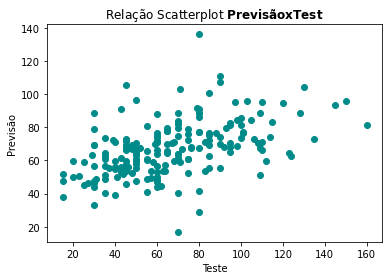

In [31]:
X_cnt = sm.add_constant(X_TesteComp)
Y_predTest = results.predict(X_cnt)

plt.title(r'Relação Scatterplot $\bf{Previsão x Test}$')
plt.xlabel('Teste')
plt.ylabel('Previsão')
plt.scatter(Y_test, Y_predTest, color='darkcyan');

In [50]:
(train.iloc[:,:4]**2).sum(1).pow(1/2)

TypeError: unsupported operand type(s) for ** or pow(): 'str' and 'int'